# Solving the Line Extending Game with Traditional RL

*Note: this is a development notebook, code may be buggy or otherwise subpar. See `line_extending_game_0.ipynb` for a more polished version of the final result.*

Here, we develop a traditional reinforcement learning agent inspired by Q-learning to solve the line extending game described in `line_extending_game_0.ipynb`. We imagine an agent moving around the board, turning on all the pixels it deems necessary in a certain area before moving on. We'll give the agent a "view" of a 5x5 square centered on the active pixel (thereby encoding "for free" the knowledge that what to do for each pixel depends only on the values of pixels a maximum of 2 pixels away) and let it make two actions: turn on the pixel or move to the next cell. We'll also give the agent for free that it is not possible to activate a pixel that is already activated. We will drag this agent across the entire board until it makes a full pass without activating any pixels.

The agent's policy is represented by a table where the rows are each possible state — all $2^{5*5-1} = 16,777,216$ of them — the columns are each possible action — either fill in the active pixel or move on — and the values are the quality of taking that action given that state. For training, we'll use a random exploration policy heavily biased towards the "move on" action and we'll consider the training agent done when it has activated the same number of pixels as are activated in the answer and then made a full pass over the grid after that. At the end of a training exploration, we will take as the reward the opposite of the number of pixels that differ between the produced grid and the real answer, and we'll update all the actions that were taken by that reward (no time discounting).


In [2]:
import random
import warnings
import time
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from nsai_experiments import line_extending_game_tools as lgt

### Attempt 1

In [82]:
class TraditionalAgent:
    """
    Initialize the agent for a grid with `n_rows` rows and `n_cols` cols; give it a state
    window of height `window_rows*2+1` and width `window_cols*2+1`; call `random_source` for
    a source of randomness.
    """
    def __init__(self, *, window_rows = 2, window_cols = 2, random_source = random.random):
        self._window_rows = window_rows
        self._window_cols = window_cols
        self._random_source = random_source
        # PERF might be better to store these together for better caching performance
        # Rows are state, cols are action (0 = move on, 1 = fill in), vals are q-value numerator
        self._q_table = np.zeros((2**((window_rows*2+1)*(window_cols*2+1)-1), 2), dtype=np.int64)
        # Rows are state, cols are action, vals are # of times encountered in training data
        self._times_encountered = np.zeros_like(self._q_table)
        self._cells_traversed = 0
    
    """
    Set the grid that the agent operates on; place the agent at the top left corner. Creates
    a copy of the grid; subsequent operations will not mutate the original.
    """
    def set_grid(self, grid):
        self._n_rows, self._n_cols = grid.shape
        # Probability of moving on during exploration. Chosen so that 10% of cells
        # are filled in after max(n_rows, n_cols) full passes over the grid
        self._exploration_bias = 1 - 0.1/max(self._n_rows, self._n_cols)
        assert np.shape(grid) == (self._n_rows, self._n_cols)
        self._padded_grid = np.pad(grid, ((self._window_rows, self._window_rows), (self._window_cols, self._window_cols)))
        self._my_row = 0
        self._my_col = 0
        self._actions_taken = []
        self._action_locations = []

    "Mark the current cell as on"
    def activate_current_cell(self):
        self._padded_grid[self._window_rows+self._my_row, self._window_cols+self._my_col] = True

    "Read the current cell"
    def read_current_cell(self):
        return self._padded_grid[self._window_rows+self._my_row, self._window_cols+self._my_col]
    
    "Get the grid with whatever modifications the agent has made to it so far"
    def get_grid(self):
        return self._padded_grid[self._window_rows:-self._window_rows, self._window_cols:-self._window_cols]
    
    "Count the total number of filled cells in the current grid"
    def count_filled_cells(self):
        return np.sum(self.get_grid())
    
    "Get the current agent state as a grid centered on the active cell (which is technically not part of the state)"
    def current_state_grid(self):
        return self._padded_grid[
            self._my_row:self._my_row+self._window_rows*2+1,
            self._my_col:self._my_col+self._window_cols*2+1]
    
    "Convert the current agent state to a number for `q_table` indexing"
    def _state_grid_to_n(self, state_grid):
        tr, tc = self._window_rows*2+1, self._window_cols*2+1
        assert np.shape(state_grid) == (tr, tc)
        # PERF could do this afterwards with bit twiddling
        without_center_cell = np.delete(state_grid.flatten(), tc*self._window_rows+self._window_cols)
        return without_center_cell.dot(2**np.arange(tr*tc-1)[::-1])
    
    "Apply the exploration policy to the state grid `s` to produce an action"
    def exploration_policy(self, s):
        return int(self._random_source() >= self._exploration_bias)
    
    "Apply the real policy to the state grid `s` to produce an action"
    def real_policy(self, s):
        idx = self._state_grid_to_n(s)
        q_row = self._q_table[idx]
        te_row = self._times_encountered[idx]
        with np.errstate(invalid = "ignore"): q_quotient = q_row/te_row
        if len(q_quotient[np.isnan(q_quotient)]) == len(q_quotient):
            warnings.warn("Encountered situation where all options lack training data, defaulting to 0")
            return 0
        elif len(q_quotient[np.isnan(q_quotient)]) > 0:
            warnings.warn("Encountered situation where some option lacks training data")
            q_quotient[np.isnan(q_quotient)] = -np.inf  # Never choose the option that hasn't been trained
        return np.argmax(q_quotient)
    
    def increment_position(self):
        self._my_col += 1
        if self._my_col >= self._n_cols:
            self._my_row += 1
            self._my_col = 0
        if self._my_row >= self._n_rows:
            self._my_row = 0
        self._cells_traversed += 1
    
    "Perform a step either with the exploration policy or the real policy"
    def step(self, real, verbose = False):
        policy = self.real_policy if real else self.exploration_policy
        state = self.current_state_grid()
        
        # If the current cell is already filled in, move on without consulting the policy
        if self.read_current_cell():
            action = 0
            if verbose: print("Moving on as active cell is already filled in")
        else:
            action = policy(state)
            self._actions_taken.append((self._state_grid_to_n(state), action))
            self._action_locations.append((self._my_row, self._my_col))  # surprise tool that will help us later
            if verbose: print(f"Policy evaluates to action {action}")
        
        if action:
            self.activate_current_cell()
        else:
            self.increment_position()
        if verbose: print(f"Position is now {(self._my_row, self._my_col)}")
        return action
    
    "Get the number of cells traversed so far"
    def get_cells_traversed(self):
        return self._cells_traversed
    
    def evaluate_reward(self, answer_grid):
        # A cell counts against us if its true value differs from the predicted value -- that's xor
        return -np.sum(np.abs(answer_grid ^ self.get_grid()))
    
    def update_q(self, reward):
        for idx in self._actions_taken:
            self._q_table[idx] += reward
            self._times_encountered[idx] += 1
    
    def train(self, problem, solution, verbose = False):
        self.set_grid(problem)
        while self.count_filled_cells() < np.sum(solution):
            self.step(False)
        for i in range(self._n_rows*self._n_cols):
            self.step(False)
        if verbose: print(f"Completed in {self._cells_traversed} steps with {len(self._actions_taken)} exploratory actions taken")
        reward = self.evaluate_reward(solution)
        if verbose: print(f"Reward is {reward}")
        self.update_q(reward)
        return self.get_grid()
    
    def run(self, problem, timeout = 100_000):
        self.set_grid(problem)
        n_cells = self._n_rows*self._n_cols
        i_last_updated = -1
        filled_cells = self.count_filled_cells()
        for i in range(timeout):
            self.step(True)
            new_filled_cells = self.count_filled_cells()
            if new_filled_cells > filled_cells:
                i_last_updated = i
            if i-i_last_updated >= n_cells:
                return self.get_grid()
            filled_cells = new_filled_cells
        warnings.warn("Run timed out without finishing")
        return self.get_grid()
    
    def test(self, problem, solution, timeout = 100_000):
        self.run(problem, timeout = timeout)
        return self.evaluate_reward(solution)

To see how this works, we'll feed the agent a fake source of randomness to control its decisions for the first two steps:

In [4]:
def fake_random_source(l):
    it = iter(l)
    return lambda: next(it)

r = fake_random_source([0.0, 1.0])
print(r())
print(r())

0.0
1.0


In [5]:
test_grid = lgt.create_grid("""
    - x - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    """)
test_agent = TraditionalAgent(random_source = fake_random_source([0.0, 1.0]))
test_agent.set_grid(test_grid)
test_agent.step(real = False, verbose = True)
lgt.display_grid(test_agent.get_grid())
test_agent.step(real = False, verbose = True)
lgt.display_grid(test_agent.get_grid())
test_agent.step(real = False, verbose = True)
lgt.display_grid(test_agent.get_grid())
test_agent._actions_taken

Policy evaluates to action 0
Position is now (0, 1)
- x - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
Moving on as active cell is already filled in
Position is now (0, 2)
- x - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
Policy evaluates to action 1
Position is now (0, 2)
- x x - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -


[(np.int64(2048), 0), (np.int64(4096), 1)]

As expected, the agent's first three moves were to move on due to the exploration policy, to move on due to the current cell already being filled in, and to fill in a cell due to the exploration policy. For another test, here's the exploration policy randomly filling in cells until 20 cells are filled:

In [6]:
empty_grid = lgt.create_grid("""
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    - - - - - - - - - - 
    """)
test_agent = TraditionalAgent()
test_agent.set_grid(test_grid)
while test_agent.count_filled_cells() < 20:
    test_agent.step(False)
print(test_agent._actions_taken)
lgt.display_grid(test_agent.get_grid())
test_agent.get_cells_traversed()

[(np.int64(2048), 0), (np.int64(4096), 0), (np.int64(8192), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(32768), 0), (np.int64(65536), 0), (np.int64(131072), 0), (np.int64(262144), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 1), (np.int64(1048576), 0), (np.int64(2097152), 0), (np.int64(4194304), 0), (np.int64(8388608), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(16384), 0), (np.int64(32768), 0), (np.int64(65536), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(524288), 0), (np.int64(1048576), 0), (np.int64(2097152), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (np.int64(0), 0), (

2123

Okay, let's train! We'll train with smaller grids to speed things up.

In [7]:
my_agent = TraditionalAgent()
random.seed(47)
progress = []
step = 10_000  # Takes about 3 minutes on my machine, decrease step for less training
for j in range(10):
    start = time.perf_counter()
    for i in range(step):
        problem, solution = lgt.generate_problem(6, 6, random.randrange(2), random.randrange(2), random.randrange(2))
        my_agent.train(problem, solution, verbose = False)
    end = time.perf_counter()
    progress.append((j*step, end-start, np.count_nonzero(my_agent._q_table, axis = 0)))
    print(j, flush=True)

0
1
2
3
4
5
6
7
8
9


How many cells of the q-table are we touching?

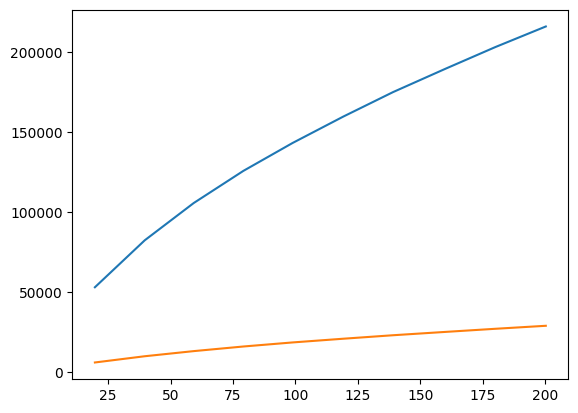

In [8]:
plt.plot(np.cumsum([t[1] for t in progress]), [t[2][0] for t in progress])
plt.plot(np.cumsum([t[1] for t in progress]), [t[2][1] for t in progress])

In [9]:
np.count_nonzero(my_agent._q_table == 0, axis = 0)

array([16561250, 16748117])

In [10]:
np.count_nonzero(my_agent._q_table != 0, axis = 0)

array([215966,  29099])

Let's test:

In [11]:
random.seed(1)
problem, solution = lgt.generate_problem(10, 10, random.randrange(2), random.randrange(3), random.randrange(4))
lgt.display_grid(problem)

- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- x - - - - - - - -
- - x - - - - - - -
- - - - - - - - - -
- - - - - - - x - -
- - - - - - - - x -
- - - - - - - - - -


In [12]:
print(my_agent.test(problem, solution))
lgt.display_grid(my_agent.get_grid())

-45
- x - x - x - x - x
- - - - - - - - - -
- x - x - x - x x x
x x - - - x - - x x
- x - - - x - - - -
- x x - - x - - - x
x x - - x x - - x -
x - x - - x - x x x
x - - x - - - - x -
x - - - x - - x x -


/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_68041/425018931.py:78: UserWarning: Encountered situation where some option lacks training data
  warnings.warn("Encountered situation where some option lacks training data")
/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_68041/425018931.py:75: UserWarning: Encountered situation where all options lack training data, defaulting to 0
  warnings.warn("Encountered situation where all options lack training data, defaulting to 0")


That is not great performance. There are many things we could try to improve this — I suspect the most important being generating more diverse training data — but for now let's be more targeted in our training.

### Attempt 2

Rather than giving all actions taken in a game the same reward/penalty based on the overall score, we'll use the value of each individual pixel to update the corresponding decisions. This is still reinforcement learning and isn't cheating per se, but it is a substantially more powerful way of training.

In [83]:
class PinpointAgent(TraditionalAgent):
    def update_q(self, solution, *, pass_reward = 10, pass_penalty = -1, fill_reward = 100, fill_penalty = -100):
        self._normalized_q = None
        actions_taken = np.array(self._actions_taken)  # Two columns: _state_grid_to_n, action (0 or 1)
        action_locations = np.array(self._action_locations)  # Two columns: row, col
        for irow in range(self._n_rows):
            for icol in range(self._n_cols):
                # All the decisions that happened at this cell (two columns: state n, action)
                relevant_actions = actions_taken[(action_locations[:, 0] == irow) & (action_locations[:, 1] == icol)]
                yes_indices = relevant_actions[:, 0][relevant_actions[:, 1] == 1]  # state ns where action is 0
                no_indices = relevant_actions[:, 0][relevant_actions[:, 1] == 0]  # state ns where action is 1
                predicted = self.get_grid()[irow, icol]
                actual = solution[irow, icol]
                match (predicted, actual):
                    case (np.True_, np.False_):  # false positive
                        # If we said yes and real was no, reward all nos, penalize the yes
                        self._q_table[no_indices, 0] += pass_reward
                        self._q_table[yes_indices, 1] += fill_penalty
                        self._times_encountered[no_indices, 0] += 1
                        self._times_encountered[yes_indices, 1] += 1
                    case (np.True_, np.True_):  # true positive
                        # If we said yes and real was yes, nothing for nos, reward the yes
                        self._q_table[yes_indices, 1] += fill_reward
                        self._times_encountered[yes_indices, 1] += 1
                    case (np.False_, np.False_):  # true negative
                        # If we said no and real was no, reward all nos, there is no yes
                        self._q_table[no_indices, 0] += pass_reward
                        self._times_encountered[no_indices, 0] += 1
                    case (np.False_, np.True_):  # false negative
                        # If we said no and real was yes, penalize all nos, there is no yes
                        self._q_table[no_indices, 0] += pass_penalty
                        self._times_encountered[no_indices, 0] += 1
                    case _:
                        assert False, "Failed to match any case"

    def train(self, problem, solution, verbose = False):
        self.set_grid(problem)
        while self.count_filled_cells() < np.sum(solution):
            self.step(False)
        for i in range(self._n_rows*self._n_cols):
            self.step(False)
        if verbose:
            print(f"Completed in {self._cells_traversed} steps with {len(self._actions_taken)} exploratory actions taken")
            print(f"{np.count_nonzero(self.get_grid() == solution)} matches out of {self._n_rows*self._n_cols}")
        self.update_q(solution)
        return self.get_grid()

So if we train it like this:

In [14]:
test_grid = lgt.create_grid("""
    - - - - - -
    - x - - - -
    - - x - - -
    - - - - - -
    - - - - - -
    - - - - - -
    """)
test_answer = lgt.create_grid("""
    x - - - - -
    - x - - - -
    - - x - - -
    - - - x - -
    - - - - x -
    - - - - - x
    """)
test_agent = PinpointAgent(random_source = fake_random_source([0.0]*34 + [1.0]*4 + [0.0]*30))
test_agent.train(test_grid, test_answer, verbose = True)
lgt.display_grid(test_agent.get_grid())
# test_agent._actions_taken

Completed in 75 steps with 68 exploratory actions taken
30 matches out of 36
x x x x - -
- x - - - -
- - x - - -
- - - - - -
- - - - - -
- - - - - -


we would expect moving on without activating to be encouraged at (1, 0) and discouraged at (3, 3), then activating the cell to be encouraged at (0, 0) and (once (0, 0) is activated) discouraged at (0, 1):

In [15]:
test_agent.set_grid(test_grid)

for coords in [(1, 0), (3, 3), (0, 0), (0, 1)]:
    test_agent._my_row, test_agent._my_col = coords
    print(test_agent._q_table[test_agent._state_grid_to_n(test_agent.current_state_grid())])
    if coords == (0, 0): test_agent.activate_current_cell()

[10  0]
[-1  0]
[  0 100]
[   0 -100]


Excellent. Let's train more and cross our fingers.

In [20]:
new_agent = PinpointAgent()
random.seed(47)
progress2 = []
step = 10_000  # Takes about 4 minutes on my machine, decrease step for less training
for j in range(10):
    start = time.perf_counter()
    for i in range(step):
        problem, solution = lgt.generate_problem(6, 6, random.randrange(2), random.randrange(2), random.randrange(2))
        new_agent.train(problem, solution, verbose = False)
    end = time.perf_counter()
    progress2.append((j*step, end-start, np.count_nonzero(new_agent._q_table, axis = 0)))
    print(j, flush=True)

0
1
2
3
4
5
6
7
8
9


In [21]:
random.seed(1)
problem, solution = lgt.generate_problem(10, 10, random.randrange(2), random.randrange(3), random.randrange(4))
lgt.display_grid(problem)

- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- x - - - - - - - -
- - x - - - - - - -
- - - - - - - - - -
- - - - - - - x - -
- - - - - - - - x -
- - - - - - - - - -


In [22]:
print(new_agent.test(problem, solution))
lgt.display_grid(new_agent.get_grid())

-9
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
x - - - - - - - - -
- x - - - - - - - -
- - x - - - - - - -
- - - x - - x - - -
- - - - - - - x - -
- - - - - - - - x -
- - - - - - - - - x


/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_68041/425018931.py:78: UserWarning: Encountered situation where some option lacks training data
  warnings.warn("Encountered situation where some option lacks training data")


It works!!! Does it work as well as the human solution?

In [23]:
random.seed(47)
scores = Counter()
for i in range(100):
    # Generate a problem with the given dimensions and number of three-length segments,
    # two-length features, and one-length features; and the corresponding solution
    problem, solution = lgt.generate_problem(10, 10, random.randrange(2), random.randrange(3), random.randrange(4))
    scores.update([new_agent.test(problem, solution)])
scores

/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_68041/425018931.py:78: UserWarning: Encountered situation where some option lacks training data
  warnings.warn("Encountered situation where some option lacks training data")
/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_68041/425018931.py:75: UserWarning: Encountered situation where all options lack training data, defaulting to 0
  warnings.warn("Encountered situation where all options lack training data, defaulting to 0")


Counter({np.int64(0): 58,
         np.int64(-1): 8,
         np.int64(-3): 8,
         np.int64(-2): 8,
         np.int64(-6): 4,
         np.int64(-8): 3,
         np.int64(-9): 3,
         np.int64(-5): 2,
         np.int64(-4): 2,
         np.int64(-17): 1,
         np.int64(-11): 1,
         np.int64(-14): 1,
         np.int64(-7): 1})

No, not quite, but not too bad. (I repeated this experiment without the division by `_times_encountered` and the number of perfectly correct predictions stayed the same and the incorrect predictions got slightly worse, so let's stick with `_times_encountered` for now.)

### Attempt 3

Now that we are able to learn pretty well, we might be able to learn faster by adopting an exploration policy that follows the real policy most of the time. That way we focus more on the edge cases and less on redundantly reinforcing things the model already knows. A hacky implementation to avoid too much code repetition:

In [91]:
class TargetedAgent(PinpointAgent):
    def exploration_policy(self, s):
        if self._random_source() < self.exploration_rate:
            return int(self._random_source() >= self._exploration_bias)
        return self.real_policy(s)

# def exploration_rate_curve(f):
#     if f <= 0.5: return 1-(f*0.9/0.5)
#     return 1-(0.9+(f-0.5)*0.15)

# def exploration_rate_curve(f):
#     return 1/(np.exp(5*f))

def exploration_rate_curve(f):
    return 1-f

newer_agent = TargetedAgent()
random.seed(47)
progress3 = []
step = 10_000
for j in range(20):
    start = time.perf_counter()
    newer_agent.exploration_rate = exploration_rate_curve(j/20)
    print(newer_agent.exploration_rate)
    for i in range(step):
        problem, solution = lgt.generate_problem(6, 6, random.randrange(2), random.randrange(2), random.randrange(2))
        newer_agent.train(problem, solution, verbose = False)
    end = time.perf_counter()
    progress3.append((j*step, end-start, np.count_nonzero(newer_agent._q_table, axis = 0)))
    print(j, flush=True)

1.0
0
0.95


/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_68041/425018931.py:75: UserWarning: Encountered situation where all options lack training data, defaulting to 0
  warnings.warn("Encountered situation where all options lack training data, defaulting to 0")
/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_68041/425018931.py:78: UserWarning: Encountered situation where some option lacks training data
  warnings.warn("Encountered situation where some option lacks training data")


1
0.9
2
0.85
3
0.8
4
0.75
5
0.7
6
0.65
7
0.6
8
0.55
9
0.5
10
0.44999999999999996
11
0.4
12
0.35
13
0.30000000000000004
14
0.25
15
0.19999999999999996
16
0.15000000000000002
17
0.09999999999999998
18
0.050000000000000044
19


Counter({np.int64(0): 91,
         np.int64(-1): 6,
         np.int64(-15): 1,
         np.int64(-5): 1,
         np.int64(-2): 1})

Seems to work. Training on bigger grids?

In [102]:
newer_agent = TargetedAgent()
random.seed(47)
progress3 = []
step = 5_000
for j in range(10):
    start = time.perf_counter()
    newer_agent.exploration_rate = exploration_rate_curve(j/10)
    print(newer_agent.exploration_rate)
    for i in range(step):
        problem, solution = lgt.generate_problem(10, 10, random.randrange(2), random.randrange(3), random.randrange(4))
        newer_agent.train(problem, solution, verbose = False)
    end = time.perf_counter()
    progress3.append((j*step, end-start, np.count_nonzero(newer_agent._q_table, axis = 0)))
    print(j, flush=True)

random.seed(47)
scores = Counter()
for i in range(100):
    # Generate a problem with the given dimensions and number of three-length segments,
    # two-length features, and one-length features; and the corresponding solution
    problem, solution = lgt.generate_problem(10, 10, random.randrange(2), random.randrange(3), random.randrange(4))
    scores.update([newer_agent.test(problem, solution)])
scores

1.0
0
0.9


/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_68041/425018931.py:78: UserWarning: Encountered situation where some option lacks training data
  warnings.warn("Encountered situation where some option lacks training data")
/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_68041/425018931.py:75: UserWarning: Encountered situation where all options lack training data, defaulting to 0
  warnings.warn("Encountered situation where all options lack training data, defaulting to 0")


1
0.8
2
0.7
3
0.6
4
0.5
5
0.4
6
0.30000000000000004
7
0.19999999999999996
8
0.09999999999999998
9


Counter({np.int64(0): 91,
         np.int64(-2): 4,
         np.int64(-5): 2,
         np.int64(-15): 1,
         np.int64(-1): 1,
         np.int64(-7): 1})

Training on $5000*10$ 10x10 grids takes about 10 minutes and gives better performance than training on $10000*20$ 6x6 grids for 7 minutes.

What do the failures look like?

In [103]:
random.seed(47)
scores = Counter()
for i in range(100):
    # Generate a problem with the given dimensions and number of three-length segments,
    # two-length features, and one-length features; and the corresponding solution
    problem, solution = lgt.generate_problem(10, 10, random.randrange(2), random.randrange(3), random.randrange(4))
    # if newer_agent.test(problem, solution) != 0:
    print(newer_agent.test(problem, solution))
    lgt.display_grid(problem)
    print()
    lgt.display_grid(newer_agent.get_grid())
    print()
    lgt.display_grid(solution)
    print("\n\n\n")
scores

/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_68041/425018931.py:78: UserWarning: Encountered situation where some option lacks training data
  warnings.warn("Encountered situation where some option lacks training data")


0
- - - - - - - - - -
- - - - - - - - - -
x x x - - - - - - -
- - - - - - - - - -
- - - - - - - x - -
- - - - - - - - - x
- - - - - - - - - -
- - - - - - - - - -
x - - - - - - - - -
- - - - - - - - - -

- - - - - - - - - -
- - - - - - - - - -
x x x x x x x x x x
- - - - - - - - - -
- - - - - - - x - -
- - - - - - - - - x
- - - - - - - - - -
- - - - - - - - - -
x - - - - - - - - -
- - - - - - - - - -

- - - - - - - - - -
- - - - - - - - - -
x x x x x x x x x x
- - - - - - - - - -
- - - - - - - x - -
- - - - - - - - - x
- - - - - - - - - -
- - - - - - - - - -
x - - - - - - - - -
- - - - - - - - - -




0
- - - - - - - - x -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - x - - - -
- - - - x - - - - -
- - - x - - - - - -

- - - - - - - - x -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - x
- - - - - - - - x -
- - - - - - - x - -
- - - - - - x - - -
- - - - - x - - - -
- - - - x - - - - -
- - - x -

Counter()

Can we get perfect results if we train *ad nauseum*?

In [104]:
newer_agent = TargetedAgent()
random.seed(47)
progress3 = []
step = 10_000
for j in range(20):
    start = time.perf_counter()
    newer_agent.exploration_rate = exploration_rate_curve(j/20)
    print(newer_agent.exploration_rate)
    for i in range(step):
        problem, solution = lgt.generate_problem(10, 10, random.randrange(2), random.randrange(3), random.randrange(4))
        newer_agent.train(problem, solution, verbose = False)
    end = time.perf_counter()
    progress3.append((j*step, end-start, np.count_nonzero(newer_agent._q_table, axis = 0)))
    print(j, flush=True)

random.seed(47)
scores = Counter()
for i in range(100):
    # Generate a problem with the given dimensions and number of three-length segments,
    # two-length features, and one-length features; and the corresponding solution
    problem, solution = lgt.generate_problem(10, 10, random.randrange(2), random.randrange(3), random.randrange(4))
    scores.update([newer_agent.test(problem, solution)])
scores

1.0
0
0.95


/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_68041/425018931.py:78: UserWarning: Encountered situation where some option lacks training data
  warnings.warn("Encountered situation where some option lacks training data")
/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_68041/425018931.py:75: UserWarning: Encountered situation where all options lack training data, defaulting to 0
  warnings.warn("Encountered situation where all options lack training data, defaulting to 0")


1
0.9
2
0.85
3
0.8
4
0.75
5
0.7
6
0.65
7
0.6
8
0.55
9
0.5
10
0.44999999999999996
11
0.4
12
0.35
13
0.30000000000000004
14
0.25
15
0.19999999999999996
16
0.15000000000000002
17
0.09999999999999998
18
0.050000000000000044
19


Counter({np.int64(0): 98, np.int64(-10): 1, np.int64(-3): 1})

In [107]:
random.seed(47)
for i in range(100):
    # Generate a problem with the given dimensions and number of three-length segments,
    # two-length features, and one-length features; and the corresponding solution
    problem, solution = lgt.generate_problem(10, 10, random.randrange(2), random.randrange(3), random.randrange(4))
    if newer_agent.test(problem, solution) != 0:
        print(newer_agent.test(problem, solution))
        lgt.display_grid(problem)
        print()
        lgt.display_grid(newer_agent.get_grid())
        print()
        lgt.display_grid(solution)
        print("\n\n\n")

/var/folders/7_/d7tqnwgs3pb_q_t94nmtckdcx9mz_y/T/ipykernel_68041/425018931.py:78: UserWarning: Encountered situation where some option lacks training data
  warnings.warn("Encountered situation where some option lacks training data")


-10
- - - - - - - - - -
x - - - x - - - - -
- - - - - - - - - -
x x - - - - - - - -
- - - - - - - - - -
- - - - x x - - - -
- - - - - - - - - -
- x x x - - - - - -
- - - - - - - - - -
- - - - - - - - x -

- - - - - - - - - -
x - - - x - - - - -
- - - - - - - - - -
x x - - - - - - - -
- - - - - - - - - -
- - x x x x x x x x
- - - - - - - - - -
x x x x x x x x x x
- - - - - - - - - -
- - - - - - - - x -

- - - - - - - - - -
x - - - x - - - - -
- - - - - - - - - -
x x x x x x x x x x
- - - - - - - - - -
x x x x x x x x x x
- - - - - - - - - -
x x x x x x x x x x
- - - - - - - - - -
- - - - - - - - x -




-3
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - - - - - - - - -
- - x - - - x - - -
- x - - - x - - - -
x - x - - - - - - -
- - - - - - - - x -
- - - - - - - - - -

- - - - - - - x - -
- - - - - - x - - -
- - - - - x - - - x
- - - - x - - - x -
- - - x - - - x - -
- - x - - - x - - -
- x - - - x - - - -
x - x - - - - - - -
- - - x - - - - x -
- - - 

We get very close. Future work should be done to see if we can get all the way there by either (a) training even longer or (b) adjusting the hyperparameters.